In [51]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt

In [52]:
df = pd.read_csv('/Users/claudio.gauna/repo/eccentricity/test/resources/upa_event_ts.csv')
df = df.sort_values(by=['datetime'])

In [53]:
df.head(2)

,datetime,code,day,hour,minute,day_name,datetime.1,count,date,month
0,1535414421259,combinedproducts-search-e-flightresults-filter...,27,20,0,Monday,1535414421259,1,2018-08-27 20:00:21.259,8
1,1535414451815,transfers-checkout-e-credit-card-completed,27,20,0,Monday,1535414451815,2,2018-08-27 20:00:51.815,8


In [54]:
def get_ts(code,df):
    values = np.float32(df[df.code == code]['count'].values)
    dim = values.shape[0]
    index = np.int64(np.array([x for x in range(1,dim+1)]))
    index = index.reshape(1,dim)
    values = values.reshape(1,dim)
    return (index, values)

In [55]:
def generate_timeseries_csv():
    codes = ['cars-search','cars-checkout','cars-thanks', 'hotels-search','hotels-checkout','hotels-thanks','flights-search','flights-checkout','flights-thanks']
    for code in codes:
        x_ts, y_ts = get_ts(code, df)
        t = pd.Series(data=y_ts.flat, index=x_ts.flat)
        t.to_csv(code + ".csv")

In [56]:
generate_timeseries_csv()

In [57]:
ts = pd.Series.from_csv('cars-search.csv')

In [58]:
x_ts = ts.index.values.reshape(1,len(ts))
y_ts = ts.values.reshape(1,len(ts))

In [48]:
LEARNING_RATE = 1.0
PERIOD = 1008
PI = np.pi
ALPHA_REG = 0.01

In [49]:
x = tf.constant(x_ts,dtype=tf.float32)

y = tf.constant(y_ts,dtype=tf.float32)

multipliers = tf.constant([(x*2*PI)/PERIOD for x in range(1,PERIOD)], dtype=tf.float32)

amplitudes_cos = tf.Variable(tf.random_uniform([1, PERIOD-1], -10, 10, seed=42))

amplitudes_sin = tf.Variable(tf.random_uniform([1, PERIOD-1], -10, 10, seed=42))

bias = tf.Variable(tf.zeros([1]))

sin_part = tf.reduce_sum(tf.sin(tf.transpose(x) * multipliers) * amplitudes_sin, 1)

cos_part = tf.reduce_sum(tf.cos(tf.transpose(x) * multipliers) * amplitudes_cos, 1)

y_pred = sin_part + cos_part + bias

error = y_pred - y

regularizer = ALPHA_REG * tf.nn.l2_loss(amplitudes_cos) + ALPHA_REG * tf.nn.l2_loss(amplitudes_sin)

mse = tf.reduce_mean(tf.square(error) + regularizer, name="mse")

op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(mse)

In [50]:
n_epochs = 1000
init = tf.global_variables_initializer()
sess = tf.Session()
with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            sess.run(op)
            print("epoch %s, mse = %s " % (epoch, mse.eval()))
        y_p = y_pred.eval()

epoch 0, mse = 180709.78 
epoch 1, mse = 169434.56 
epoch 2, mse = 161177.27 
epoch 3, mse = 155207.16 
epoch 4, mse = 150879.16 
epoch 5, mse = 147711.94 
epoch 6, mse = 145334.3 
epoch 7, mse = 143451.08 
epoch 8, mse = 141842.89 
epoch 9, mse = 140364.25 
epoch 10, mse = 138928.44 
epoch 11, mse = 137488.77 
epoch 12, mse = 136024.69 
epoch 13, mse = 134532.47 
epoch 14, mse = 133017.67 
epoch 15, mse = 131493.14 
epoch 16, mse = 129973.445 
epoch 17, mse = 128471.93 
epoch 18, mse = 126999.07 
epoch 19, mse = 125562.07 
epoch 20, mse = 124166.766 
epoch 21, mse = 122818.51 
epoch 22, mse = 121520.97 
epoch 23, mse = 120276.66 
epoch 24, mse = 119086.125 
epoch 25, mse = 117947.414 
epoch 26, mse = 116855.34 
epoch 27, mse = 115802.445 
epoch 28, mse = 114780.42 
epoch 29, mse = 113782.266 
epoch 30, mse = 112802.69 
epoch 31, mse = 111837.97 
epoch 32, mse = 110885.44 
epoch 33, mse = 109944.0 
epoch 34, mse = 109013.79 
epoch 35, mse = 108095.35 
epoch 36, mse = 107189.86 
epoch 3

KeyboardInterrupt: 

NameError: name 'y_p' is not defined

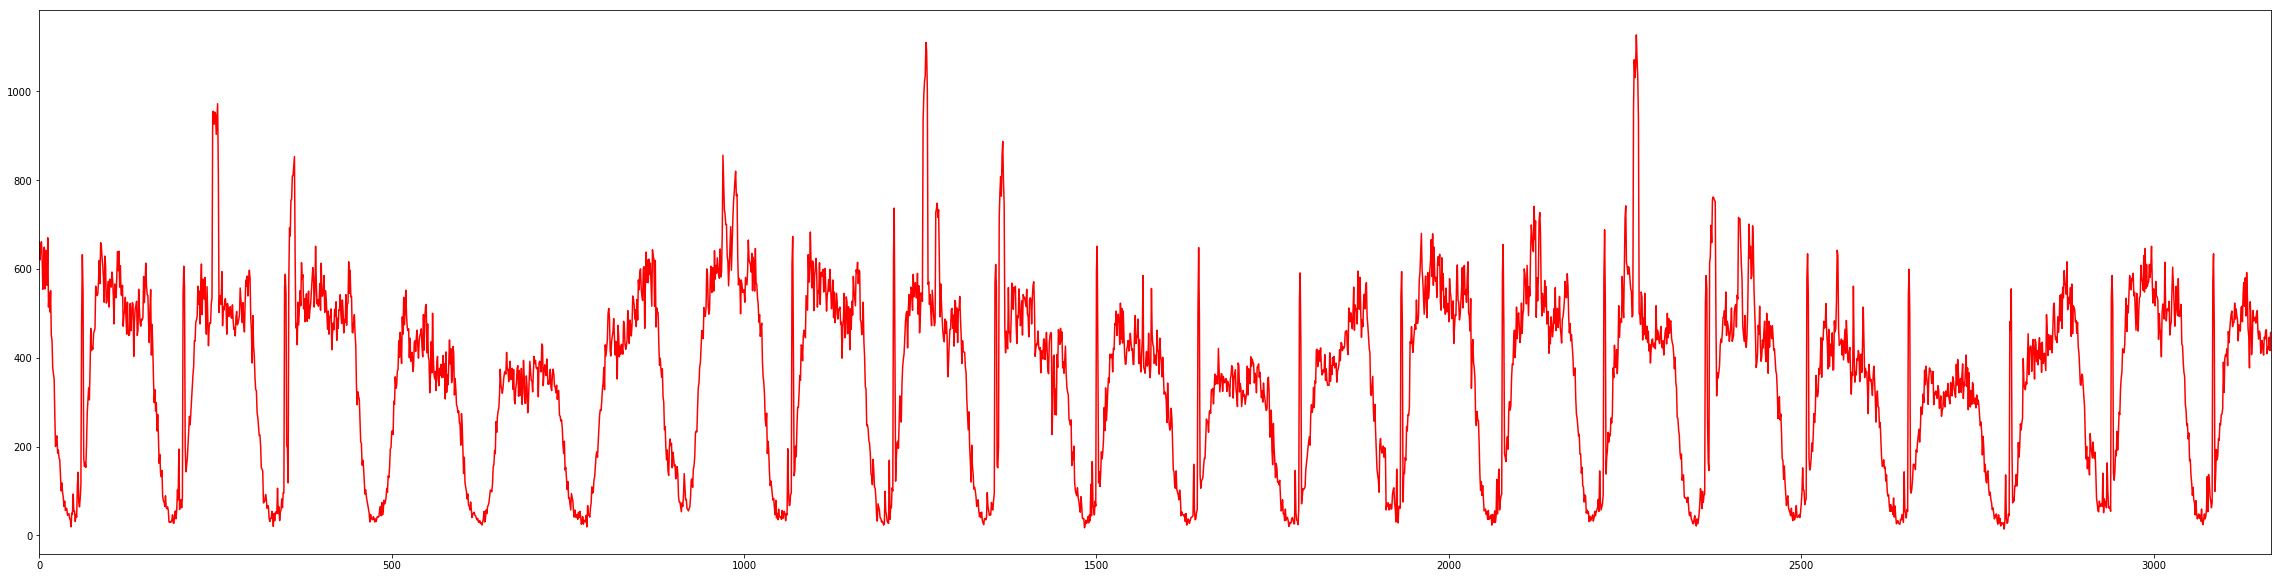

In [59]:
plt.figure(figsize=(40,10))
sbn.tsplot(y_ts, color="red")
sbn.tsplot(y_p, color="blue")

In [379]:
s = pd.Series()

In [ ]:
s.to_csv